### Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline
sys.path.append("..")

from utils import label_map_util
from utils import visualization_utils as vis_util
from utils import path_detection_utils as path_util

### Loading in model 

In [2]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

### Object Detection on specific frame

In [15]:
path1 = 'video_frames/frame199.jpg'
path2 = 'test_images/pic.jpg'
image = Image.open(path1)
width, height = image.size
image_np = path_util.load_image_into_numpy_array(image)
boxes, scores, classes = path_util.get_segmentation(path1,detection_graph, category_index, False)
human_boxes, human_scores = path_util.remove_non_human(boxes, scores, classes)
good_boxes, good_scores = path_util.remove_low_prob(human_boxes, human_scores)

In [16]:
good_boxes

array([[ 0.66268861,  0.76430535,  0.91769922,  0.95044839],
       [ 0.71908724,  0.00726274,  0.99429595,  0.27347773],
       [ 0.70754254,  0.56746179,  0.81422746,  0.667898  ],
       [ 0.7245267 ,  0.5121507 ,  0.82025355,  0.58241218],
       [ 0.58722848,  0.8509692 ,  0.80595964,  1.        ],
       [ 0.70317495,  0.63293004,  0.8110975 ,  0.68855274],
       [ 0.70121044,  0.67291409,  0.83550459,  0.76337737],
       [ 0.71651626,  0.48091426,  0.81067991,  0.56059557],
       [ 0.70372689,  0.68322605,  0.90518641,  0.83455211]], dtype=float32)

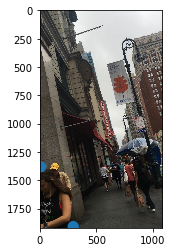

In [18]:
from matplotlib.patches import Circle

# Make some example data
i=1
x = [good_boxes[i][1]*width, good_boxes[i][3]*width]
y = [good_boxes[i][0]*height, good_boxes[i][2]*height]

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(image_np)

# Now, loop through coord arrays, and create a circle at each x,y pair
for xx,yy in zip(x,y):
    circ = Circle((xx,yy),50)
    ax.add_patch(circ)

# Show the image
plt.show()

In [38]:
last_iter_people = deg

In [20]:
def get_box_similarity_score(box1, box2, img_w, img_h, method=1):
    return 5

SyntaxError: unexpected EOF while parsing (<ipython-input-20-7f3da7ef4d6a>, line 1)